# 서울시 공원현황 분석

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline
# 한글폰트 사용
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

In [2]:
import folium
import json
geo_str = json.load(open('./data/skorea_municipalities_geo_simple.json',
                         encoding='utf8'))

### 데이터 파악하고 정리하기

In [3]:
park = pd.read_csv('./data/서울시 주요 공원현황(수정).csv')
park.head(3)

,공원번호,공원명,공원개요,면적,개원일,주요시설,주요식물,안내도,오시는길,이용시참고사항,이미지,지역,공원주소,관리부서,전화번호,X좌표(GRS80TM),Y좌표(GRS80TM),X좌표(WGS84),Y좌표(WGS84),바로가기
0,1,남산도시자연공원,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,2896887㎡ 2454140㎡ 442747㎡,1968.9.10,기반시설 : 광장 45950㎡ 도로 108530㎡ 산책로 6.7㎞ (북측:3.7㎞/...,소나무 단풍 아카시아 상수리나무 등 191종 2881870주,http://parks.seoul.go.kr/upload/seditorMulti/2...,명동역(남산케이블카 와룡묘 서울애니메이션센터 방면) 도보 명동역 3번출구 → 퍼시픽...,남산공원 차량통행 금지안내 2005년 5월 1일부터 남산공원에 일반승용차 택시 통행...,http://parks.seoul.go.kr/file/info/view.do?fId...,중구,서울특별시 중구 삼일대로 231(예장동),서울특별시중부푸른도시사업소,02-3783-5900,198364.107,450395.554,126.990377,37.550140,http://parks.seoul.go.kr/template/sub/namsan.do
1,3,길동생태공원,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...,80683㎡,1999.5.20,탐방객안내소 야외전시대 관찰대 목재데크 조류관찰대 길동생태문화센터,소나무 보리수 등 64종 31800주 산국 부들 등 138종 192800본,http://parks.seoul.go.kr/template/common/img/p...,NaN,매주 월요일은 휴관입니다 사전예약 후 입장하실 수 있습니다. ▶ 인터넷 예약 바로가...,http://parks.seoul.go.kr/file/info/view.do?fId...,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),동부공원녹지사업소 길동생태공원,02-489-2770,213554.120,448852.675,127.154779,37.540394,http://parks.seoul.go.kr/template/sub/gildong.do
2,4,서울대공원,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 재미와 즐거...,9132690㎡,1984.5.1,동물원 식물원 테마가든(장미원 어린이동물원 피크닉장) 치유숲 산림욕장 캠핑장 국립현...,NaN,NaN,지하철 4호선 대공원역 하차(2번 출구) 도보 15분 정도 문의처 02)500-73...,일반사항 공원을 깨끗하게 이용합니다. 대중교통을 이용해 주세요. 기념물 시설물 풀과...,http://parks.seoul.go.kr/file/info/view.do?fId...,과천시,경기도 과천시 대공원광장로 102,전략기획실,02-500-7032,200994.267,437163.981,127.019847,37.426449,http://grandpark.seoul.go.kr/


In [4]:
def calc_area(s):
    if s == '0':
        return 0

    num_list = s.strip().split('㎡')
    area = 0
    for num_str in num_list:
        if num_str == '':
            continue
        area += float(num_str)

    return area

In [5]:
park['면적'][park['면적'].isnull()] = '0'
park['area'] = park['면적'].map(calc_area)
park[['면적','area']].head()

,면적,area
0,2896887㎡ 2454140㎡ 442747㎡,5793774.0
1,80683㎡,80683.0
2,9132690㎡,9132690.0
3,480994㎡,480994.0
4,2284085㎡,2284085.0


In [6]:
park_new = park[['공원명','지역','공원주소','area','공원개요']]
park_new.head()

,공원명,지역,공원주소,area,공원개요
0,남산도시자연공원,중구,서울특별시 중구 삼일대로 231(예장동),5793774.0,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...
1,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),80683.0,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...
2,서울대공원,과천시,경기도 과천시 대공원광장로 102,9132690.0,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 재미와 즐거...
3,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),480994.0,당초 골프장 승마장 등이 있던 뚝섬일대를 주거업무 지역으로 개발할 경우 약 4조원에...
4,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),2284085.0,월드컵공원은 서울의 서쪽에 위치하여 1978년부터 1993년까지 15년간 서울시민이...


In [7]:
import requests
from urllib.parse import quote

key_fd = open('../06.RestAPI/kakaomapkey.txt', mode='r')
kmap_key = key_fd.read(100)
key_fd.close()

In [8]:
lat_list, lng_list = [], []
for i in park_new.index:
    try:
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + quote(park_new['공원주소'][i])
        result = requests.get(url,
                headers={"Authorization": "KakaoAK "+kmap_key}).json()
        lat = float(result['documents'][0]['y'])
        lng = float(result['documents'][0]['x'])
        lat_list.append(lat)
        lng_list.append(lng)
    except:
        print(park_new['공원명'][i], park_new['공원주소'][i])

In [9]:
park_new['lat'], park_new['lng'] = lat_list, lng_list
park_new.head()

,공원명,지역,공원주소,area,공원개요,lat,lng
0,남산도시자연공원,중구,서울특별시 중구 삼일대로 231(예장동),5793774.0,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,37.555633,126.992218
1,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),80683.0,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...,37.539066,127.153329
2,서울대공원,과천시,경기도 과천시 대공원광장로 102,9132690.0,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 재미와 즐거...,37.436431,127.014098
3,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),480994.0,당초 골프장 승마장 등이 있던 뚝섬일대를 주거업무 지역으로 개발할 경우 약 4조원에...,37.543070,127.041799
4,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),2284085.0,월드컵공원은 서울의 서쪽에 위치하여 1978년부터 1993년까지 15년간 서울시민이...,37.572327,126.881889


In [10]:
park_new.area.min(), park_new.area.max()

(0.0, 10420819.08)

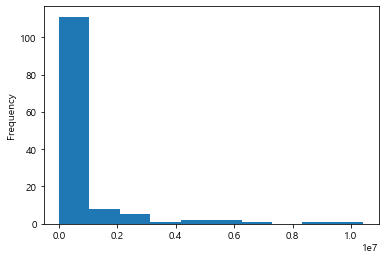

In [11]:
park_new.area.plot(kind='hist')
plt.show()

In [12]:
area_criteria = [-1, 100000, 1000000, 12000000]
labels = ['소형', '중형', '대형']
size_info = [3, 7, 15]
park_new['scale'] = pd.cut(park_new.area, area_criteria, labels=labels)
park_new['size'] = pd.cut(park_new.area, area_criteria, labels=size_info)
park_new.head()

,공원명,지역,공원주소,area,공원개요,lat,lng,scale,size
0,남산도시자연공원,중구,서울특별시 중구 삼일대로 231(예장동),5793774.0,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,37.555633,126.992218,대형,15
1,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),80683.0,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...,37.539066,127.153329,소형,3
2,서울대공원,과천시,경기도 과천시 대공원광장로 102,9132690.0,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 재미와 즐거...,37.436431,127.014098,대형,15
3,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),480994.0,당초 골프장 승마장 등이 있던 뚝섬일대를 주거업무 지역으로 개발할 경우 약 4조원에...,37.543070,127.041799,중형,7
4,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),2284085.0,월드컵공원은 서울의 서쪽에 위치하여 1978년부터 1993년까지 15년간 서울시민이...,37.572327,126.881889,대형,15


In [13]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11)
for i in park_new.index:
    folium.CircleMarker([park_new.lat[i], park_new.lng[i]], 
                        radius=int(park_new['size'][i]),
                        tooltip=f"{park_new['공원명'][i]}({int(park_new.area[i])}㎡)",
                        color='#3186cc', fill_color='#3186cc').add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>서울시내 공원 위치와 크기</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map

In [14]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
for i in park_new.index:
    folium.CircleMarker([park_new.lat[i], park_new.lng[i]], 
                        radius=int(park_new['size'][i]),
                        tooltip=f"{park_new['공원명'][i]}({int(park_new.area[i])}㎡)",
                        color='green', fill_color='green').add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>서울시내 공원 위치와 크기</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map

In [15]:
park_new.to_csv('./results/04.park_info.csv', encoding='utf8')

### 자치구별 공원 분석

In [16]:
park_gu = park_new.groupby('지역').sum()
park_gu['공원수'] = park_new.groupby('지역').count()['area']
del park_gu['lat']
del park_gu['lng']
park_gu.drop(['과천시'], inplace=True)
park_gu.rename(columns={'area': '공원면적'}, inplace=True)
park_gu.head()

,공원면적,공원수
지역,,
강남구,3626398.50,7
강동구,1526389.30,7
강북구,3714902.40,4
강서구,2194154.10,9
관악구,10431453.08,2


#### 구별 공원수

In [17]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
map.choropleth(geo_data = geo_str,
               data = park_gu['공원수'],
               columns = [park_gu.index, park_gu['공원수']],
               fill_color = 'PuRd',
               key_on = 'feature.id')
for i in park_new.index:
    folium.CircleMarker([park_new.lat[i], park_new.lng[i]], 
                        radius=int(park_new['size'][i]),
                        tooltip=f"{park_new['공원명'][i]}({int(park_new.area[i])}㎡)",
                        color='green', fill_color='green').add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>자치구별 공원수</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map    

#### 구별 공원면적

In [18]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
map.choropleth(geo_data = geo_str,
               data = park_gu['공원면적'],
               columns = [park_gu.index, park_gu['공원면적']],
               fill_color = 'PuRd',
               key_on = 'feature.id')
for i in park_new.index:
    folium.CircleMarker([park_new.lat[i], park_new.lng[i]], 
                        radius=int(park_new['size'][i]),
                        tooltip=f"{park_new['공원명'][i]}({int(park_new.area[i])}㎡)",
                        color='green', fill_color='green').add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>자치구별 공원면적</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map  

### 자치구별 공원면적 비율

In [19]:
df = pd.read_csv('./data/서울시 자치구 면적(2019).tsv', sep='\t', header=1)
df.drop([0], inplace=True)
del df['기간']
df.set_index('자치구', inplace=True)
df.head()

,면적,구성비(%),행정,법정,통,반
자치구,,,,,,
종로구,23.91,4.0,17,87,278,"1,479"
중구,9.96,1.6,15,74,253,"1,580"
용산구,21.87,3.6,16,36,351,"2,550"
성동구,16.86,2.8,17,17,466,"3,619"
광진구,17.06,2.8,15,7,363,"2,999"


In [20]:
park_gu['구면적'] = df['면적'] * 1000000
park_gu.head()

,공원면적,공원수,구면적
지역,,,
강남구,3626398.50,7,39500000.0
강동구,1526389.30,7,24590000.0
강북구,3714902.40,4,23600000.0
강서구,2194154.10,9,41440000.0
관악구,10431453.08,2,29570000.0


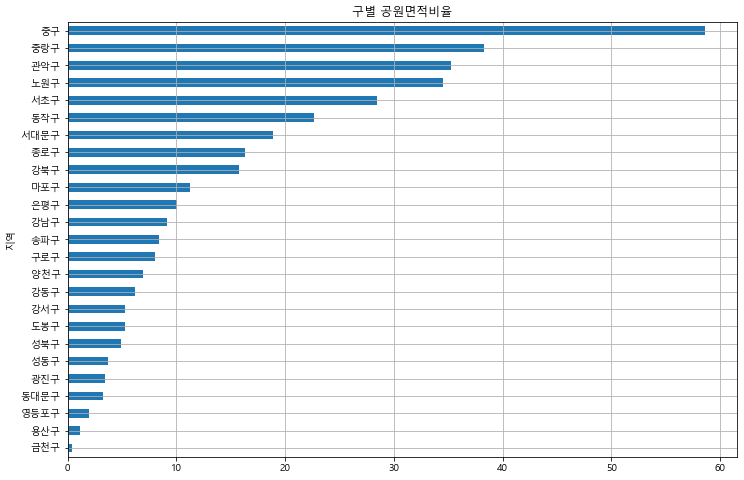

In [21]:
park_gu['공원면적비율'] = park_gu['공원면적'] / park_gu['구면적'] * 100
park_gu['공원면적비율'].sort_values().plot(kind='barh', grid=True, figsize=(12,8))
plt.title('구별 공원면적비율')
plt.show()

In [22]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
map.choropleth(geo_data = geo_str,
               data = park_gu['공원면적비율'],
               columns = [park_gu.index, park_gu['공원면적비율']],
               fill_color = 'PuRd',
               key_on = 'feature.id')
for i in park_new.index:
    folium.CircleMarker([park_new.lat[i], park_new.lng[i]], 
                        radius=int(park_new['size'][i]),
                        tooltip=f"{park_new['공원명'][i]}({int(park_new.area[i])}㎡)",
                        color='green', fill_color='green').add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>자치구별 공원면적 비율</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map

### 자치구별 인당 공원면적

In [23]:
df = pd.read_csv('./results/01.cctv.csv')
df.set_index('구별', inplace=True)
df.head()

,소계,최근증가율,인구수,내국인,외국인,고령자,외국인비율,고령자비율,cctv비율,오차
구별,,,,,,,,,,
강남구,5221,52.171379,544085,539235,4850,73942,0.891405,13.590156,0.959593,2579.013268
강동구,1879,82.960078,462275,458058,4217,68798,0.912228,14.882483,0.406468,526.315431
강북구,1265,83.068017,313550,309996,3554,62951,1.133472,20.076862,0.403444,710.063146
강서구,1617,77.887789,589536,583544,5992,88052,1.016393,14.935814,0.274284,1156.473682
관악구,3985,99.150425,514555,498574,15981,78206,3.105790,15.198764,0.774456,1428.441743


In [24]:
park_gu['인구수'] = df['인구수']
park_gu['인당공원면적'] = park_gu['공원면적'] / park_gu['인구수']
park_gu.head()

,공원면적,공원수,구면적,공원면적비율,인구수,인당공원면적
지역,,,,,,
강남구,3626398.50,7,39500000.0,9.180756,544085,6.665132
강동구,1526389.30,7,24590000.0,6.207358,462275,3.301908
강북구,3714902.40,4,23600000.0,15.741112,313550,11.847879
강서구,2194154.10,9,41440000.0,5.294773,589536,3.721832
관악구,10431453.08,2,29570000.0,35.277149,514555,20.272766


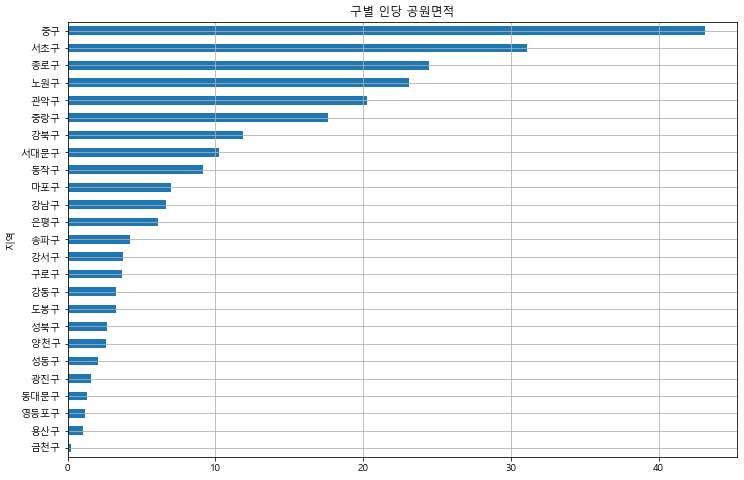

In [25]:
park_gu['인당공원면적'].sort_values().plot(kind='barh', grid=True, figsize=(12,8))
plt.title('구별 인당 공원면적')
plt.show()

In [26]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')
map.choropleth(geo_data = geo_str,
               data = park_gu['인당공원면적'],
               columns = [park_gu.index, park_gu['인당공원면적']],
               fill_color = 'PuRd',
               key_on = 'feature.id')
for i in park_new.index:
    folium.CircleMarker([park_new.lat[i], park_new.lng[i]], 
                        radius=int(park_new['size'][i]),
                        tooltip=f"{park_new['공원명'][i]}({int(park_new.area[i])}㎡)",
                        color='green', fill_color='green').add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>자치구별 인당 공원면적</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map

### 생활환경 만족도

In [27]:
df = pd.read_csv('./data/서울시 생활환경 만족도(2019).tsv', sep='\t')
del df['기간']
del df['대분류']
rows = list(range(35))
df.drop(rows, inplace=True)
df.set_index('분류', inplace=True)
df.head()

,주거환경,경제환경,사회환경,교육환경
분류,,,,
종로구,6.43,5.68,5.99,5.98
중구,6.39,5.22,5.89,5.53
용산구,6.16,5.67,6.11,6.09
성동구,6.47,5.42,5.92,5.84
광진구,6.68,5.78,6.38,5.97


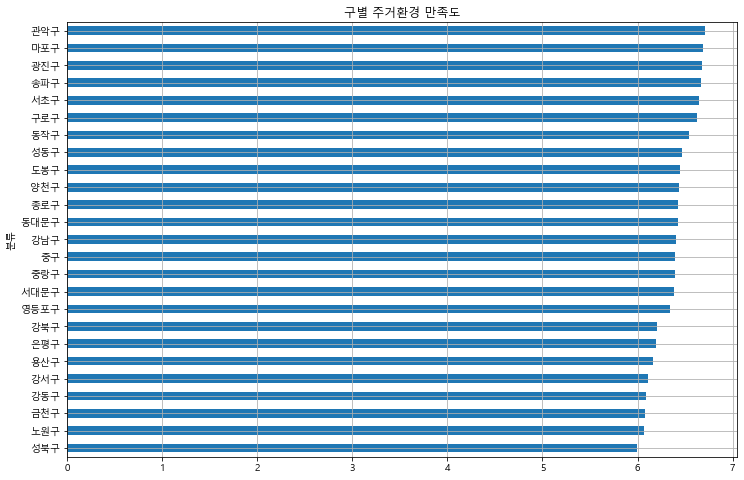

In [28]:
df['주거환경'].sort_values().plot(kind='barh', grid=True, figsize=(12,8))
plt.title('구별 주거환경 만족도')
plt.show()

In [29]:
park_gu['주거환경만족도'] = df['주거환경']
park_gu['인당공원면적비율'] = park_gu['인당공원면적'] / park_gu['인당공원면적'].values.max() \
                                * park_gu['주거환경만족도'].values.max()
park_gu.head()

,공원면적,공원수,구면적,공원면적비율,인구수,인당공원면적,주거환경만족도,인당공원면적비율
지역,,,,,,,,
강남구,3626398.50,7,39500000.0,9.180756,544085,6.665132,6.40,1.036262
강동구,1526389.30,7,24590000.0,6.207358,462275,3.301908,6.09,0.513364
강북구,3714902.40,4,23600000.0,15.741112,313550,11.847879,6.20,1.842049
강서구,2194154.10,9,41440000.0,5.294773,589536,3.721832,6.11,0.578652
관악구,10431453.08,2,29570000.0,35.277149,514555,20.272766,6.71,3.151909


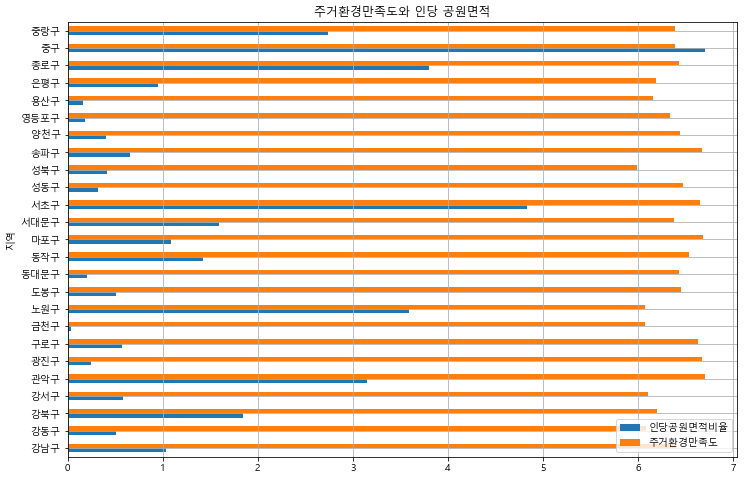

In [30]:
park_gu[['인당공원면적비율','주거환경만족도']].plot(kind='barh', grid=True, figsize=(12,8))
plt.title('주거환경만족도와 인당 공원면적')
plt.show()

### 초미세먼지 vs 공원

In [31]:
df = pd.read_csv('./data/서울시 초미세먼지(2019).csv')
df.drop([0], inplace=True)
df.set_index('구분', inplace=True)
df.head()

,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
구분,,,,,,,,,,,,
강남구,43,40,46,18,26,16,18,16,11,14,20,27
강동구,42,39,44,18,27,18,19,18,13,17,25,36
강북구,39,36,42,16,25,17,19,17,13,17,21,31
강서구,37,35,46,19,27,18,21,19,14,18,26,30
관악구,41,39,49,27,34,23,14,12,11,15,19,27


In [32]:
df['초미세먼지'] = df.mean(axis=1)
df.head()

,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월,초미세먼지
구분,,,,,,,,,,,,,
강남구,43,40,46,18,26,16,18,16,11,14,20,27,24.583333
강동구,42,39,44,18,27,18,19,18,13,17,25,36,26.333333
강북구,39,36,42,16,25,17,19,17,13,17,21,31,24.416667
강서구,37,35,46,19,27,18,21,19,14,18,26,30,25.833333
관악구,41,39,49,27,34,23,14,12,11,15,19,27,25.916667


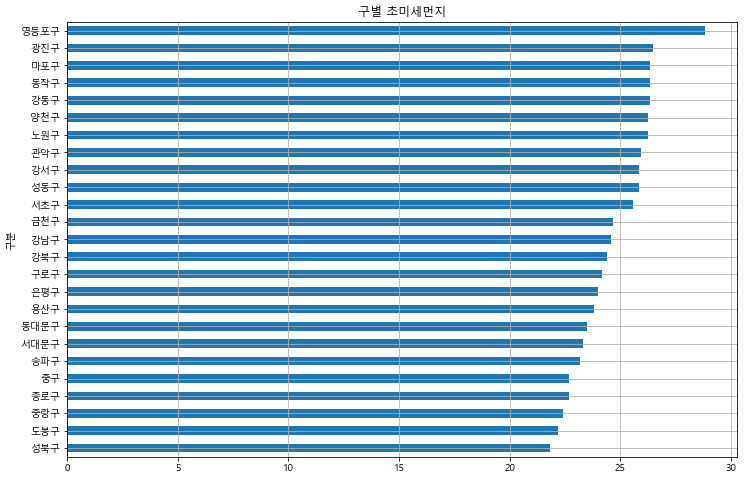

In [33]:
df['초미세먼지'].sort_values().plot(kind='barh', grid=True, figsize=(12,8))
plt.title('구별 초미세먼지')
plt.show()

In [34]:
park_gu['초미세먼지'] = df['초미세먼지']
np.corrcoef(park_gu['공원면적비율'], park_gu['초미세먼지'])

array([[ 1.        , -0.17052509],
       [-0.17052509,  1.        ]])

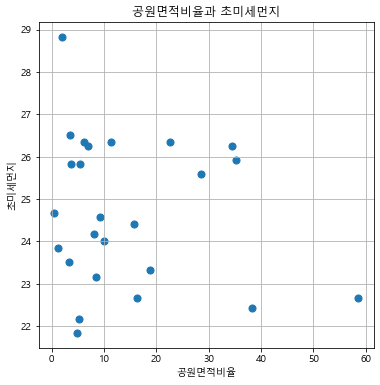

In [35]:
# 공원면적비율과 초미세먼지의 산점도
plt.figure(figsize=(6,6))
plt.scatter(park_gu['공원면적비율'], park_gu['초미세먼지'], s=50)
plt.grid(True)
plt.title('공원면적비율과 초미세먼지')
plt.xlabel('공원면적비율')
plt.ylabel('초미세먼지')
plt.show()

In [36]:
fp1 = np.polyfit(park_gu['공원면적비율'], park_gu['초미세먼지'], 1)
fx = np.array([0, 60])
f1 = np.poly1d(fp1)
fy = f1(fx)
fy

array([24.99090475, 23.758434  ])

In [37]:
park_gu['오차'] = np.abs(park_gu['초미세먼지'] - f1(park_gu['공원면적비율']))
park_sort = park_gu.sort_values('오차', ascending=False)
park_sort.head()

,공원면적,공원수,구면적,공원면적비율,인구수,인당공원면적,주거환경만족도,인당공원면적비율,초미세먼지,오차
지역,,,,,,,,,,
영등포구,485990.00,5,24550000.0,1.979593,405982,1.197073,6.34,0.186115,28.833333,3.883092
성북구,1198327.00,3,24570000.0,4.877196,449871,2.663712,5.99,0.414141,21.833333,3.057388
도봉구,1084218.00,6,20660000.0,5.247909,329300,3.292493,6.45,0.511901,22.166667,2.716440
종로구,3907680.57,12,23910000.0,16.343290,159842,24.447145,6.43,3.800921,22.666667,1.988528
노원구,12235699.30,3,35440000.0,34.525111,529532,23.106629,6.07,3.592504,26.250000,1.968282


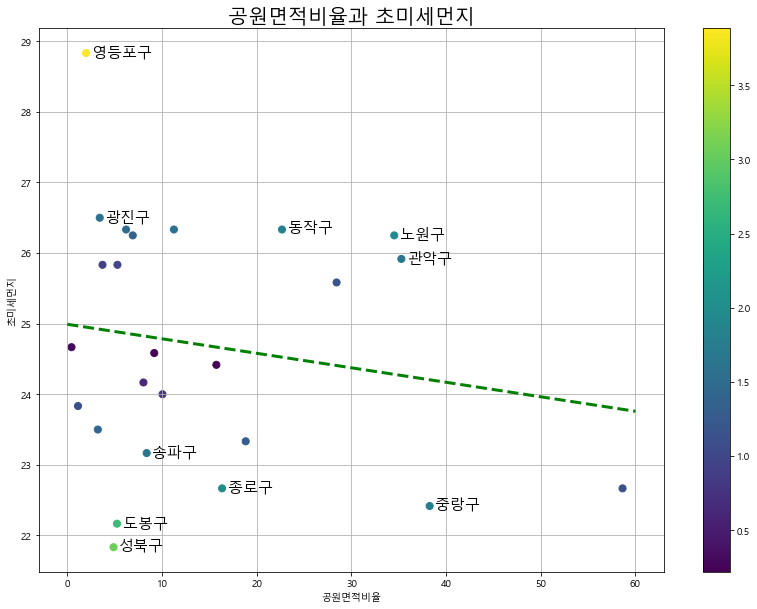

In [38]:
plt.figure(figsize=(14,10))
plt.scatter(park_gu['공원면적비율'], park_gu['초미세먼지'], c=park_gu['오차'], s=50)
plt.plot(fx, fy, ls='dashed', lw=3, color='g')

for i in range(10): 
    plt.text(park_sort['공원면적비율'][i]+0.6, park_sort['초미세먼지'][i]-0.05,
             park_sort.index[i], fontsize=15)

plt.grid(True)
plt.title('공원면적비율과 초미세먼지', fontsize=20)
plt.xlabel('공원면적비율')
plt.ylabel('초미세먼지')
plt.colorbar()
plt.show()

In [39]:
park_gu.to_csv('./results/04.park_gu.csv')

### 강서구 공원 현황

In [40]:
addr = '서울특별시 강서구 화곡로 302 (화곡동)'      # 강서구청
url = 'https://dapi.kakao.com/v2/local/search/address.json?query='+quote(addr)
result = requests.get(url,
            headers={"Authorization": "KakaoAK "+kmap_key}).json()
lat = float(result['documents'][0]['y'])
lng = float(result['documents'][0]['x'])
lat, lng

(37.5509655144007, 126.849532173376)

In [41]:
map = folium.Map(location=[37.5509655, 126.849532], zoom_start=13)
gangseogu = park_new[park_new['지역'] == '강서구']
for i in gangseogu.index:
    folium.CircleMarker([gangseogu.lat[i], gangseogu.lng[i]], 
                        radius=int(gangseogu['size'][i])*3,
                        tooltip=f"{gangseogu['공원명'][i]}({int(gangseogu.area[i])}㎡)",
                        color='#3186cc', fill_color='#3186cc').add_to(map)
title_html = '<h3 align="center" style="font-size:20px"><b>강서구 공원 현황</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map